In [2]:
import sys
import json
import os
os.environ['CUDA_VISIBLE_DEVICES']='5'

import fire
# import gradio as gr
import torch
import transformers
from peft import PeftModel
from transformers import GenerationConfig, LlamaForCausalLM, LlamaTokenizer, AutoTokenizer, AutoModelForCausalLM, AutoModel, TextStreamer

# from utils.prompter import Prompter
import bitsandbytes as bnb
import warnings
warnings.filterwarnings('ignore')


===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
bin /data/Yucong/anaconda3/lib/python3.9/site-packages/bitsandbytes/libbitsandbytes_cuda113.so
CUDA SETUP: CUDA runtime path found: /data/Yucong/anaconda3/lib/libcudart.so.11.0
CUDA SETUP: Highest compute capability among GPUs detected: 8.0
CUDA SETUP: Detected CUDA version 113
CUDA SETUP: Loading binary /data/Yucong/anaconda3/lib/python3.9/site-packages/bitsandbytes/libbitsandbytes_cuda113.so...


/data/Yucong/anaconda3/lib/python3.9/site-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: Found duplicate ['libcudart.so', 'libcudart.so.11.0', 'libcudart.so.12.0'] files: {PosixPath('/data/Yucong/anaconda3/lib/libcudart.so.11.0'), PosixPath('/data/Yucong/anaconda3/lib/libcudart.so')}.. We'll flip a coin and try one of these, in order to fail forward.
Either way, this might cause trouble in the future:
If you get `CUDA error: invalid device function` errors, the above might be the cause and the solution is to make sure only one ['libcudart.so', 'libcudart.so.11.0', 'libcudart.so.12.0'] in the paths that we search based on your env.
  warn(msg)
2023-09-30 13:03:28.232955: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [3]:
print(torch.cuda.is_available())

True


In [4]:
load_8bit = False
base_model = 'meta-llama/Llama-2-7b-chat-hf'
model_path = 'meta-llama/Llama-2-7b-chat-hf'
model_name = 'LLaMA2'

if torch.cuda.is_available():
    device = "cuda"

In [5]:
if model_name in ['ziya', 'Qwen', 'LLaMA2']:
    print('Loading tokenizer...')
    tokenizer = AutoTokenizer.from_pretrained(base_model, trust_remote_code=True)

    print('Loading model...')
    model = AutoModelForCausalLM.from_pretrained(
        base_model,
        load_in_8bit=load_8bit,
        torch_dtype=torch.float16,
        device_map="auto",
        trust_remote_code=True
    )

    if not load_8bit:
        model.half()  # seems to fix bugs for some users.

    model.eval()

    if torch.__version__ >= "2" and sys.platform != "win32":
        model = torch.compile(model)


Loading tokenizer...
Loading model...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [6]:
import json
import os.path as osp
from typing import Union


class Prompter_LLaMA2(object):
    __slots__ = ("template", "_verbose")

    def __init__(self, verbose: bool = False):
        super().__init__()

    def generate_prompt(
        self,
        instruction: str,
        input: Union[None, str] = None,
    ) -> str:        
        if input:
            prompt = instruction + input
        else:
            prompt = instruction
        system_message = "Please give a proper response to the instruction. Do not say 'I don't know."
        prompt_template=f'''[INST] <<SYS>>
{system_message}
<</SYS>>

{prompt} [/INST]'''
        
        return prompt_template

    def get_response(self, output: str) -> str:
        return output.split('[/INST]')[-1].strip(tokenizer.eos_token).strip()

prompter = Prompter_LLaMA2()

def evaluate(
    instruction,
    input=None,
    temperature=0.1,
    top_p=0.75,
    top_k=40,
    num_beams=1,
    max_new_tokens=4096,
    **kwargs,
):
    
    streamer = TextStreamer(tokenizer)
    prompt = prompter.generate_prompt(instruction, input)
    inputs = tokenizer(prompt, return_tensors="pt")
    input_ids = inputs["input_ids"].to(device)
    generation_config = GenerationConfig(
        temperature=temperature,
        top_p=top_p,
        top_k=top_k,
        num_beams=num_beams,
        **kwargs,
    )
    with torch.no_grad():
        generation_output = model.generate(
            input_ids=input_ids,
            generation_config=generation_config,
            return_dict_in_generate=True,
            output_scores=True,
            max_new_tokens=max_new_tokens,
            # streamer=streamer,
        )
    s = generation_output.sequences[0]
    output = tokenizer.decode(s, skip_special_tokens=True)
    return instruction, prompter.get_response(output)

In [7]:
instruction = 'hello'
instruction, response = evaluate(instruction)
print(response)

Hello! It's nice to meet you. How can I assist you today?


In [26]:
import pandas as pd
from recbole.quick_start import load_data_and_model
dataset_name = 'ml-100k'
rec_model_path = '../RecBole/experiments/ml-100k/LightGCN/LightGCN-Aug-28-2023_11-31-16.pth'

config, rec_model, dataset, train_data, valid_data, test_data = load_data_and_model(
    model_file=rec_model_path,
)

df_item = pd.read_csv(f'dataset/{dataset_name}/{dataset_name}.item', sep='\t')
df_inter = pd.read_csv(f'dataset/{dataset_name}/{dataset_name}.inter', sep='\t')
if 'ml' in dataset_name:
    df_user = pd.read_csv(f'dataset/{dataset_name}/{dataset_name}.user', sep='\t')

30 Sep 13:33    INFO  
General Hyper Parameters:
gpu_id = 6
use_gpu = True
seed = 2020
state = INFO
reproducibility = True
data_path = /data/Yucong/anaconda3/lib/python3.9/site-packages/recbole/config/../dataset_example/ml-100k
checkpoint_dir = experiments/ml-100k/LightGCN
show_progress = True
save_dataset = False
dataset_save_path = None
save_dataloaders = False
dataloaders_save_path = None
log_wandb = True

Training Hyper Parameters:
epochs = 500
train_batch_size = 4096
learner = adam
learning_rate = 0.0005
train_neg_sample_args = {'distribution': 'uniform', 'sample_num': 1, 'alpha': 1.0, 'dynamic': False, 'candidate_num': 0}
eval_step = 1
stopping_step = 10
clip_grad_norm = None
weight_decay = 0.0
loss_decimal_place = 4

Evaluation Hyper Parameters:
eval_args = {'group_by': 'user', 'order': 'TO', 'split': {'LS': 'valid_and_test'}, 'mode': 'full'}
repeatable = False
metrics = ['NDCG', 'Recall', 'MRR']
topk = [10, 20]
valid_metric = NDCG@10
valid_metric_bigger = True
eval_batch_size =

In [27]:
from tqdm import tqdm
def get_valid_user_list(df):
    valid_user_list = []
    for id in tqdm(df['user_id:token'].unique().tolist()):
        if len(df_inter[df_inter['user_id:token'] == id]) >=5:
            valid_user_list.append(id)
        if len(valid_user_list) == 1000:
            break
    return valid_user_list
valid_user_list = get_valid_user_list(df_inter)
valid_user_list

100%|██████████| 943/943 [00:00<00:00, 4440.45it/s]


[196,
 186,
 22,
 244,
 166,
 298,
 115,
 253,
 305,
 6,
 62,
 286,
 200,
 210,
 224,
 303,
 122,
 194,
 291,
 234,
 119,
 167,
 299,
 308,
 95,
 38,
 102,
 63,
 160,
 50,
 301,
 225,
 290,
 97,
 157,
 181,
 278,
 276,
 7,
 10,
 284,
 201,
 287,
 246,
 242,
 249,
 99,
 178,
 251,
 81,
 260,
 25,
 59,
 72,
 87,
 42,
 292,
 20,
 13,
 138,
 60,
 57,
 223,
 189,
 243,
 92,
 241,
 254,
 293,
 127,
 222,
 267,
 11,
 8,
 162,
 279,
 145,
 28,
 135,
 32,
 90,
 216,
 250,
 271,
 265,
 198,
 168,
 110,
 58,
 237,
 94,
 128,
 44,
 264,
 41,
 82,
 262,
 174,
 43,
 84,
 269,
 259,
 85,
 213,
 121,
 49,
 155,
 68,
 172,
 19,
 268,
 5,
 80,
 66,
 18,
 26,
 130,
 256,
 1,
 56,
 15,
 207,
 232,
 52,
 161,
 148,
 125,
 83,
 272,
 151,
 54,
 16,
 91,
 294,
 229,
 36,
 70,
 14,
 295,
 233,
 214,
 192,
 100,
 307,
 297,
 193,
 113,
 275,
 219,
 218,
 123,
 158,
 302,
 23,
 296,
 33,
 154,
 77,
 270,
 187,
 170,
 101,
 184,
 112,
 133,
 215,
 69,
 104,
 240,
 144,
 191,
 61,
 142,
 177,
 203,
 21,
 197,
 13

# User Profile

In [28]:
from recbole.utils.case_study import full_sort_topk
def get_instruction_ml(idx):
    # user_info
    user_info = df_user[df_user["user_id:token"] == int(idx)]
    user_age = user_info["age:token"].values[0]
    user_gender = 'male' if user_info["gender:token"].values[0] == 'M' else 'female'
    user_occupation = user_info["occupation:token"].values[0]

    # history_inter_info
    df_inter_user = df_inter[df_inter['user_id:token'] == int(idx)]
    his_id_list = df_inter_user['item_id:token'].tolist()[-10:] 
    uid_series = dataset.token2id(dataset.uid_field, [idx])
    topk_score, topk_iid_list = full_sort_topk(uid_series, rec_model, test_data, k=1, device=config['device'])
    rec_list = dataset.id2token(dataset.iid_field, topk_iid_list.cpu()) 

    # next_item_info
    next_item = df_item[df_item["item_id:token"] == int(rec_list)]
    next_item_title = next_item["movie_title:token_seq"].values[0]
    next_item_class = next_item["class:token_seq"].values[0]

    instruction = 'The history films watched by the customer are:\n'
    for i, id in enumerate(his_id_list):
        instruction += f'{i+1}: {df_item[df_item["item_id:token"] == id]["movie_title:token_seq"].values[0]}' + '\n'
        instruction += f'The class of the movie is {df_item[df_item["item_id:token"] == id]["class:token_seq"].values[0]}.\n'

    # print(f"The age of the customer is {user_age}, the gender is {user_gender} and the customer's occupation is {user_occupation}.")


    instruction += f"""
The recommender system suggests the customer to watch this movie with the following title and class:
{next_item_title}.
The class of the movie is {next_item_class}.

Your mission is to infer the customer's information from the history record, such as age, gender, occupation, etc.
You must infer age, gender, and occupation. Do not return other information. And DO NOT return Unknow or Null.
DO NOT RETURN OTHER INFORMATION!!! Only return the JSON format below!!!! So that the system can evaluate your answer.
The output format is using JSON format as follows:
{{
    "user age": "<accurate number of age>",
    "user gender": "male or female",
    "user occupation": "<occupation>"
}}
"""
    return instruction


def get_instruction_mind(idx):
    # history_inter_info
    df_inter_user = df_inter[df_inter['user_id:token'] == int(idx)]
    his_id_list = df_inter_user['item_id:token'].tolist()[-10:]
    uid_series = dataset.token2id(dataset.uid_field, [idx])
    topk_score, topk_iid_list = full_sort_topk(uid_series, rec_model, test_data, k=1, device=config['device'])
    rec_list = dataset.id2token(dataset.iid_field, topk_iid_list.cpu()) 
    # next_item_info
    next_item = df_item[df_item["item_id:token"] == int(rec_list)]
    next_item_title = next_item["title:token_seq"].values[0]
    next_item_category = next_item["category:token_seq"].values[0]
    next_item_sub_category = next_item["sub_category:token_seq"].values[0]
    next_item_abstract = next_item["abstract:token_seq"].values[0]


    instruction = 'The history news viewed by the customer are:\n'
    for i, id in enumerate(his_id_list):
        item = df_item[df_item["item_id:token"] == id]
        item_title = item["title:token_seq"].values[0]
        item_category = item["category:token_seq"].values[0]
        item_sub_category = item["sub_category:token_seq"].values[0]

        instruction += f'{i+1}: {item_title}' + '\n'
        instruction += f'The category of the news is {item_category}.\n'
        instruction += f'The sub category of the news is {item_sub_category}.\n'

    instruction += f"""
As a recommender system in the news domin, according to the user's previous news viewing history , \
tell the customer why he or she needs to watch this news.
Give reasons why the customer needs to watch this news with the following title and category:
{next_item_title}.
The category of the news is {next_item_category}.
The sub category of the news is {next_item_sub_category}.

Use ONLY the information mentioned above, especially the history record. \
You're responding to the CUSTOMER. Directly tell the customer the reason. \
Respond in SHORT and CONCISE language. Your response should be WITHIN 75 words.

"""
    return instruction

def get_instruction_steam(idx):
    # history_inter_info
    df_inter_user = df_inter[df_inter['user_id:token'] == int(idx)]
    his_id_list = df_inter_user['product_id:token'].tolist()[-10:]
    uid_series = dataset.token2id(dataset.uid_field, [idx])
    topk_score, topk_iid_list = full_sort_topk(uid_series, rec_model, test_data, k=1, device=config['device'])
    rec_list = dataset.id2token(dataset.iid_field, topk_iid_list.cpu()) 
    # next_item_info
    next_item = df_item[df_item["id:token"] == int(rec_list)]
    next_item_title = next_item["app_name:token"].values[0]
    next_item_tag = next_item["genres:token_seq"].values[0]
    next_item_price = next_item["price:float"].values[0]


    instruction = 'The history games played by the customer are:\n'
    for i, id in enumerate(his_id_list):
        item = df_item[df_item["id:token"] == id]
        item_title = item["app_name:token"].values[0]
        item_tag = item["genres:token_seq"].values[0]

        instruction += f'{i+1}: {item_title}' + '\n'
        instruction += f'The tags of the game are {item_tag}.\n'

    instruction += f"""
As a recommender system in the game playing domain, according to the user's HISTORICAL play record , \
tell the customer why he or she needs to play this game, and what are the advantages of this game.
Give reasons why the customer needs to play this game with the following title and tags:
{next_item_title}.
The tags of the game are {next_item_tag}.
The price of the game is {next_item_price}.

You can infer the game's information from the history record, such as price. \
Use ONLY the information mentioned above, especially the history record. \
You're responding to the CUSTOMER. Directly tell the customer the reason. \
Respond in SHORT and CONCISE language. Your response should be WITHIN 75 words.

The output format is as follows:
Game information: <only number of the price>
Recommendation reason: <reason>
"""
    return instruction

if dataset_name == 'ml-100k':
    get_instruction = get_instruction_ml
elif dataset_name == 'mind_small_dev':
    get_instruction = get_instruction_mind
elif dataset_name == 'steam':
    get_instruction = get_instruction_steam

In [29]:
instruction, response = evaluate(get_instruction(str(200)))
# print(instruction)
print(response)

Based on the history of movies watched by the customer, I can infer the following information about the customer:
{
    "user age": "40-50",
    "user gender": "male",
    "user occupation": "entertainment enthusiast"
}

Explanation:

Based on the customer's history of watching a mix of action, adventure, drama, romance, sci-fi, and war movies, it is likely that the customer is a male in the age range of 40-50 who is interested in entertainment and enjoys a variety of genres.


In [30]:
import json
import re
json_part = re.search(r'\{(.+?)\}', response, re.DOTALL).group()
json_data = json.loads(json_part)
json_data

{'user age': '40-50',
 'user gender': 'male',
 'user occupation': 'entertainment enthusiast'}

In [31]:
from tqdm import tqdm
import random
import warnings
warnings.filterwarnings("ignore")

# random.shuffle(valid_user_list)

# result_save_path = f'./results/LLaMA2/{dataset_name}/'
# if not os.path.exists(result_save_path):
#     os.makedirs(result_save_path)

count = {}
for key in ['age', 'gender', 'occupation']:
    if key not in count.keys():
        count.update({key: 0})
acc = {}
for key in ['age', 'gender', 'occupation']:
    if key not in acc.keys():
        acc.update({f'{key}_acc': 0})

pbar = tqdm(valid_user_list[:1000])
length = 0
for id in pbar:
    length += 1
    if length == 100:
        break
    # user_info
    user_info = df_user[df_user["user_id:token"] == int(id)]
    user_age = user_info["age:token"].values[0]
    user_gender = 'male' if user_info["gender:token"].values[0] == 'M' else 'female'
    user_occupation = user_info["occupation:token"].values[0] 

    try:
        # print(id)
        instruction, response = evaluate(get_instruction_ml(str(id)))
        json_part = re.search(r'\{(.+?)\}', response, re.DOTALL).group()
        json_data = json.loads(json_part)
        # print(json_data)
        if abs(json_data['user age'] - user_age) <= 5:
            count['age'] += 1
        # print(json_data['user gender'], user_gender)
        if json_data['user gender'] == user_gender:
            count['gender'] += 1
        if json_data['user occupation'] == user_occupation:
            count['occupation'] += 1
        for key in ['age', 'gender', 'occupation']:
            acc.update({f'{key}_acc': count[key] / length})
            pbar.set_postfix(acc, refresh=True)
    except KeyboardInterrupt:
        print('Interrupted by user')
        break
    except Exception:
        length -= 1
        continue

 15%|█▍        | 137/943 [13:31<1:19:31,  5.92s/it, age_acc=0.303, gender_acc=0.727, occupation_acc=0.0202]


In [32]:
id = 298
user_info = df_user[df_user["user_id:token"] == int(id)]
user_age = user_info["age:token"].values[0]
user_gender = 'male' if user_info["gender:token"].values[0] == 'M' else 'female'
user_occupation = user_info["occupation:token"].values[0] 

instruction, response = evaluate(get_instruction_ml(str(id)))
json_part = re.search(r'\{(.+?)\}', response, re.DOTALL).group()
json_data = json.loads(json_part)

print(json_data['user gender'], user_gender)
print(json_data['user gender'] == user_gender)

male male
True


# Item Popularity

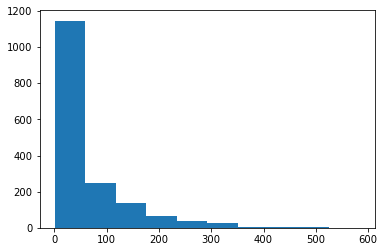

In [33]:
import matplotlib.pyplot as plt

def cal_item_pop(df_inter):
    item_pop = {}
    for i in range(len(df_inter)):
        item_id = df_inter.iloc[i]['item_id:token']
        if item_id in item_pop:
            item_pop[item_id] += 1
        else:
            item_pop[item_id] = 1
    return item_pop

def visualize_item_pop(item_pop):
    plt.hist(item_pop.values(), bins=10)
    plt.show()

item_pop = cal_item_pop(df_inter)
visualize_item_pop(item_pop)

for key, value in item_pop.items():
    if value < 50:
        item_pop[key] = 1
    elif value < 100:
        item_pop[key] = 2
    elif value < 150:
        item_pop[key] = 3
    elif value < 200:
        item_pop[key] = 4
    elif value >= 200:
        item_pop[key] = 5

In [35]:
from recbole.utils.case_study import full_sort_topk

def get_instruction_ml_popularity(idx):
    # user_info
    user_info = df_user[df_user["user_id:token"] == int(idx)]
    user_age = user_info["age:token"].values[0]
    user_gender = 'male' if user_info["gender:token"].values[0] == 'M' else 'female'
    user_occupation = user_info["occupation:token"].values[0]

    # history_inter_info
    df_inter_user = df_inter[df_inter['user_id:token'] == int(idx)]
    his_id_list = df_inter_user['item_id:token'].tolist()[-10:] 
    uid_series = dataset.token2id(dataset.uid_field, [idx])
    topk_score, topk_iid_list = full_sort_topk(uid_series, rec_model, test_data, k=1, device=config['device'])
    rec_list = dataset.id2token(dataset.iid_field, topk_iid_list.cpu()) 

    # next_item_info
    next_item = df_item[df_item["item_id:token"] == int(rec_list)]
    next_item_title = next_item["movie_title:token_seq"].values[0]
    next_item_class = next_item["class:token_seq"].values[0]
    
    instruction = 'The popularity of the movie ranges from 1 to 5, 1 means the least popular and 5 means the most popular.\n'
    instruction += 'The history films watched by the customer are:\n'
    for i, id in enumerate(his_id_list):
        instruction += f'{i+1}: {df_item[df_item["item_id:token"] == id]["movie_title:token_seq"].values[0]}' + '\n'
        instruction += f'The class of the movie is {df_item[df_item["item_id:token"] == id]["class:token_seq"].values[0]}. '
        instruction += f'And the popularity of the movie is {item_pop[id]}.\n'

    instruction += f"""
The recommender system suggests the customer to watch this movie with the following title and class:
{next_item_title}.
The class of the movie is {next_item_class}.

Your mission is to infer the movie's popularity from the history record.
You must infer popularity. Do not return other information. And DO NOT return Unknow or Null.
DO NOT RETURN OTHER INFORMATION!!! Only return the JSON format below!!!! So that the system can evaluate your answer.
The output format is using JSON format as follows:
{{
    "popularity": "<accurate number of popularity in 1-5>"
}}
"""
    return instruction

In [36]:
instruction, response = evaluate(get_instruction_ml_popularity(str(3)))
# print(instruction)
print(response)
import json
import re
json_part = re.search(r'\{(.+?)\}', response, re.DOTALL).group()
json_data = json.loads(json_part.replace(",", ''))
json_data

{
    "popularity": 5,
}

Explanation:
Based on the history record provided, the movie "English Patient, The" belongs to the class of Drama Romance War, which is consistent with the recommender system's suggestion. The popularity of the movie is 5, which is the highest level of popularity among all the movies listed in the history record.


{'popularity': 5}

In [37]:
from tqdm import tqdm
import random
import warnings
warnings.filterwarnings("ignore")

# random.shuffle(valid_user_list)

# result_save_path = f'./results/LLaMA2/{dataset_name}/'
# if not os.path.exists(result_save_path):
#     os.makedirs(result_save_path)

count = 0
pbar = tqdm(valid_user_list[:1000])
length = 0
for id in pbar:
    length += 1
    if length == 100:
        break
    # user_info
    user_info = df_user[df_user["user_id:token"] == int(id)]
    user_age = user_info["age:token"].values[0]
    user_gender = 'male' if user_info["gender:token"].values[0] == 'M' else 'female'
    user_occupation = user_info["occupation:token"].values[0] 

    df_inter_user = df_inter[df_inter['user_id:token'] == int(id)]
    his_id_list = df_inter_user['item_id:token'].tolist()[-10:] 
    uid_series = dataset.token2id(dataset.uid_field, [str(id)])
    topk_score, topk_iid_list = full_sort_topk(uid_series, rec_model, test_data, k=1, device=config['device'])
    rec_list = dataset.id2token(dataset.iid_field, topk_iid_list.cpu()) 
    item_popularity = item_pop[int(rec_list)]
    
    try:
    # print(id)
        instruction, response = evaluate(get_instruction_ml_popularity(str(id)))
        json_part = re.search(r'\{(.+?)\}', response, re.DOTALL).group()
        json_data = json.loads(json_part.replace(",", '')) 
        popularity = int(json_data['popularity'])
        # print(popularity, item_popularity)
        if popularity == item_popularity:
            count += 1
        pbar.set_postfix({'popularity_acc': count / length}, refresh=True)

    except KeyboardInterrupt:
        print('Interrupted by user')
        break
    except Exception:
        length -= 1
        continue

  0%|          | 0/943 [00:00<?, ?it/s]

 11%|█         | 100/943 [02:47<23:29,  1.67s/it, popularity_acc=0.747]
